<a href="https://colab.research.google.com/github/nadkomash/malaria_recognition/blob/main/malara_recognition_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.transform import resize



Loading data from tfds

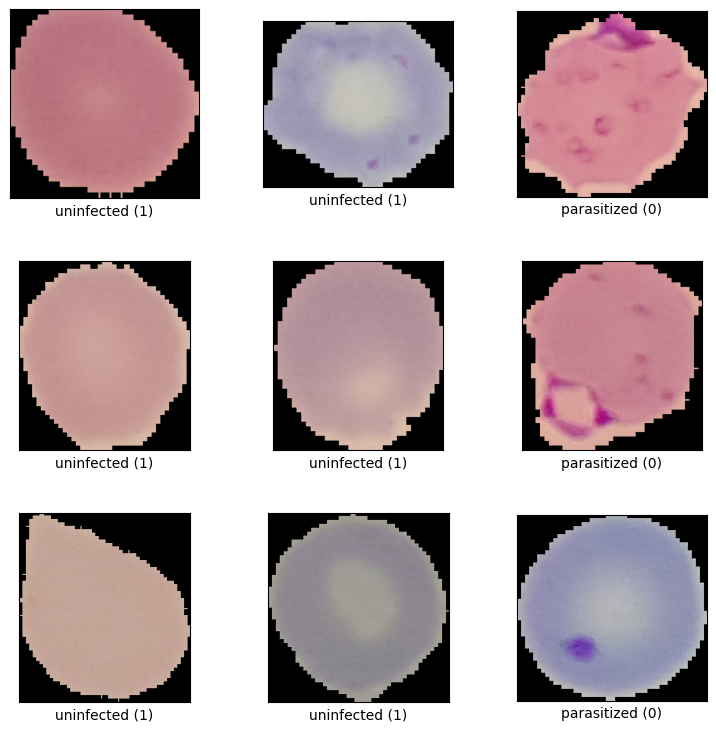

In [47]:
malaria, info = tfds.load('malaria',split='train[:2500]',with_info=True)
fig = tfds.show_examples(malaria,info)


Logistic Regression on data

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

converting to numpy array , resizing and flattenining.

In [49]:
images = []
labels =[]
for example in tfds.as_numpy(malaria):
  images.append(resize(example['image'],(100,100)))
  labels.append(example['label'])
  if len(images)==2500:
    break

X = np.array(images)
y = np.array(labels)

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.20,random_state=42)

X_train = X_train.flatten().reshape((X_train.shape[0],-1))
X_test = X_test.flatten().reshape((X_test.shape[0],-1))

print(X_train.shape)
print(X_test.shape)



(2000, 30000)
(500, 30000)


In [50]:
lr = LogisticRegression(max_iter=1000,random_state=42)
lr = lr.fit(X_train,y_train)
test_acc = lr.score(X_test,y_test)
print(f'Test Accuracy for Logistic Regression : {test_acc:.3f}')


KeyboardInterrupt: 

modeling with keras NN

In [51]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , Dropout

In [52]:
model = Sequential()
model.add(Dense(300 ,input_shape=(30000,), activation= 'relu',name='my_dense_layer'))
model.add(Dense(100 ,activation= 'relu'))
model.add(Dense(50 ,activation= 'relu'))
model.add(Dense(1 ,activation= 'sigmoid'))
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_dense_layer (Dense)          │ (None, 300)            │     9,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,035,501 (34.47 MB)

 Trainable params: 9,035,501 (34.47 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.layers[0].name
W1,b1 = model.get_layer('my_dense_layer').get_weights()
print(W1.shape)
W1

(30000, 300)


array([[ 0.00506833,  0.00198225,  0.00589175, ...,  0.00608499,
         0.0073587 ,  0.00372067],
       [ 0.0126543 , -0.0010432 , -0.00545436, ..., -0.01153849,
        -0.00382721, -0.00068785],
       [-0.00382011,  0.00393096, -0.00822086, ..., -0.00426051,
        -0.00695823,  0.00523135],
       ...,
       [ 0.01016789, -0.00502024,  0.00913952, ..., -0.00640075,
        -0.00050193, -0.00041144],
       [-0.00388972, -0.00581524,  0.00666488, ..., -0.0035404 ,
         0.01396684,  0.00227227],
       [ 0.0139892 , -0.00961793,  0.01278589, ..., -0.00278023,
         0.01037467,  0.00635615]], dtype=float32)

Compiling

In [54]:
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=["accuracy"])

Fitting

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor = 'val_loss',patience=5,restore_best_weights=True)]

history1 = model.fit(X_train,y_train, batch_size= 100, epochs=50 ,validation_split=0.1, callbacks=callbacks,verbose=0)

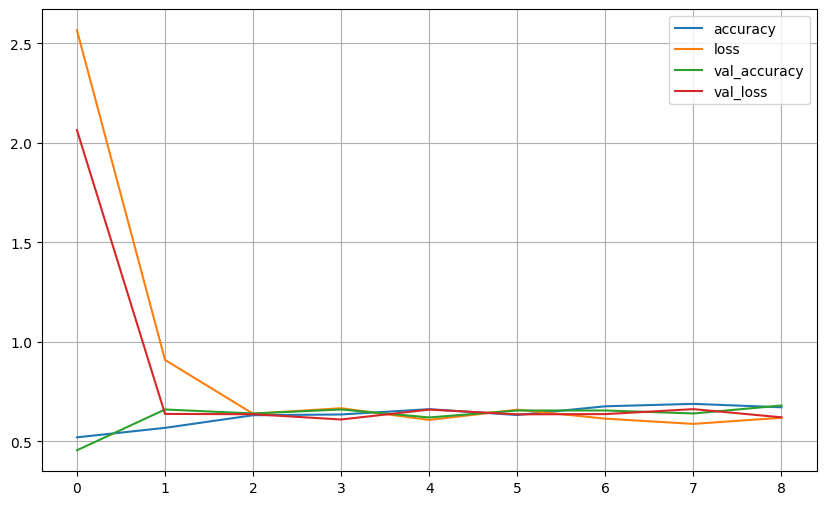

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history1.history).plot(figsize=(10,6))
plt.grid(True)
plt.show()

Evaluation

In [57]:
test_loss , test_acc = model.evaluate(X_test,y_test,verbose=False)
print(f'Test accuracy for NN: {test_acc:.3f}')

Test accuracy for NN: 0.630


In [58]:
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test , verbose=0)>0.5).astype(int).reshape(y_test.shape)
c_m  = pd.DataFrame(
    confusion_matrix(y_test,y_pred),
    index=['true:yes','true:no'],
    columns=['pred:yes','pred:no'])
print(c_m)


          pred:yes  pred:no
true:yes       107      143
true:no         42      208


Tuning parameters: (Keras tuner)

In [59]:
!pip install scikeras

In [60]:
!pip install keras

In [83]:
from tensorflow.keras.layers import  InputLayer
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping


In [87]:

# Define malaria model builder function
def malaria_model(n_hidden, n_neurons, learning_rate):
    model = Sequential()

    # Input layer: here input_shape=(30000,) means your data has 30,000 features per sample
    model.add(InputLayer(input_shape=(30000,)))

    # Hidden layers
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        loss="binary_crossentropy",
        optimizer=SGD(learning_rate=learning_rate),
        metrics=["accuracy"]
    )


    return model

# Wrap the Keras model for scikit-learn compatibility
keras_clf = KerasClassifier(
    model=malaria_model,
    n_hidden=1,
    n_neurons=30,
    learning_rate=3e-3,
    epochs=50
)


params = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100),
    'learning_rate': reciprocal(3e-4, 3e-2)
}


callbacks = [EarlyStopping(monitor = 'val_loss',patience=5,restore_best_weights=True)]

history1 = model.fit(X_train,y_train, batch_size= 100, epochs=50 ,validation_split=0.1, callbacks=callbacks,verbose=0)
# Randomized search with cross-validation
rnd_search_cv = RandomizedSearchCV(estimator=keras_clf, param_distributions=params, n_iter=10, cv=5)
# Fit the search
rnd_search_cv.fit( X_train, y_train, validation_split=0.1,callbacks=callbacks)

# Print results
print(f"Best test accuracy: {rnd_search_cv.best_score_:.2f}")
print(f"Best params: {rnd_search_cv.best_params_}")



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5167 - loss: 0.6969 - val_accuracy: 0.5813 - val_loss: 0.6816
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5524 - loss: 0.6840 - val_accuracy: 0.6250 - val_loss: 0.6662
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5610 - loss: 0.6785 - val_accuracy: 0.6562 - val_loss: 0.6584
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6044 - loss: 0.6677 - val_accuracy: 0.6500 - val_loss: 0.6550
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5883 - loss: 0.6654 - val_accuracy: 0.6250 - val_loss: 0.6522
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6394 - loss: 0.6485 - val_accuracy: 0.6125 - val_loss: 0.6551
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6119 - loss: 0.6495 - val_accuracy: 0.6625 - val_loss: 0.6422
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6306 - loss: 0.6504 - val_accuracy: 0.6750 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5648 - loss: 0.6804 - val_accuracy: 0.5938 - val_loss: 0.6726
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5977 - loss: 0.6728 - val_accuracy: 0.5562 - val_loss: 0.6698
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6217 - loss: 0.6566 - val_accuracy: 0.6000 - val_loss: 0.6686
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5973 - loss: 0.6577 - val_accuracy: 0.5875 - val_loss: 0.6605
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6003 - loss: 0.6572 - val_accuracy: 0.6125 - val_loss: 0.6621
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6102 - loss: 0.6471 - val_accuracy: 0.5562 - val_loss: 0.6686
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6038 - loss: 0.6438 - val_accuracy: 0.5562 - val_loss: 0.6693
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6250 - loss: 0.6466 - val_accuracy: 0.6062 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5231 - loss: 0.7040 - val_accuracy: 0.5813 - val_loss: 0.6778
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5867 - loss: 0.6732 - val_accuracy: 0.5500 - val_loss: 0.6717
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5999 - loss: 0.6650 - val_accuracy: 0.6062 - val_loss: 0.6621
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6019 - loss: 0.6578 - val_accuracy: 0.5500 - val_loss: 0.6952
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6070 - loss: 0.6486 - val_accuracy: 0.6313 - val_loss: 0.6531
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6422 - loss: 0.6286 - val_accuracy: 0.5750 - val_loss: 0.6649
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6278 - loss: 0.6427 - val_accuracy: 0.6000 - val_loss: 0.6500
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6391 - loss: 0.6328 - val_accuracy: 0.5938 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5443 - loss: 0.6962 - val_accuracy: 0.6000 - val_loss: 0.6780
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5988 - loss: 0.6763 - val_accuracy: 0.5813 - val_loss: 0.6743
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5933 - loss: 0.6730 - val_accuracy: 0.6375 - val_loss: 0.6660
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6023 - loss: 0.6677 - val_accuracy: 0.6625 - val_loss: 0.6622
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6211 - loss: 0.6565 - val_accuracy: 0.5813 - val_loss: 0.6612
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6123 - loss: 0.6582 - val_accuracy: 0.5875 - val_loss: 0.6584
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6223 - loss: 0.6568 - val_accuracy: 0.6438 - val_loss: 0.6505
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6122 - loss: 0.6531 - val_accuracy: 0.5875 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5547 - loss: 0.6882 - val_accuracy: 0.5625 - val_loss: 0.6693
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5795 - loss: 0.6828 - val_accuracy: 0.6125 - val_loss: 0.6707
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5694 - loss: 0.6694 - val_accuracy: 0.6625 - val_loss: 0.6587
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6148 - loss: 0.6648 - val_accuracy: 0.6438 - val_loss: 0.6570
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6282 - loss: 0.6477 - val_accuracy: 0.6062 - val_loss: 0.6587
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6143 - loss: 0.6541 - val_accuracy: 0.6187 - val_loss: 0.6567
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6292 - loss: 0.6452 - val_accuracy: 0.6062 - val_loss: 0.6411
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6728 - loss: 0.6338 - val_accuracy: 0.6062 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5303 - loss: 0.7292 - val_accuracy: 0.6000 - val_loss: 0.6780
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5528 - loss: 0.6803 - val_accuracy: 0.6250 - val_loss: 0.6676
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5857 - loss: 0.6695 - val_accuracy: 0.6313 - val_loss: 0.6592
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6272 - loss: 0.6587 - val_accuracy: 0.6687 - val_loss: 0.6522
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6346 - loss: 0.6483 - val_accuracy: 0.6625 - val_loss: 0.6435
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6517 - loss: 0.6423 - val_accuracy: 0.6125 - val_loss: 0.6541
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6418 - loss: 0.6491 - val_accuracy: 0.6625 - val_loss: 0.6348
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6289 - loss: 0.6504 - val_accuracy: 0.5688 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5127 - loss: 0.8241 - val_accuracy: 0.5188 - val_loss: 0.6883
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5384 - loss: 0.6873 - val_accuracy: 0.5188 - val_loss: 0.6845
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5758 - loss: 0.6803 - val_accuracy: 0.5250 - val_loss: 0.6800
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5833 - loss: 0.6715 - val_accuracy: 0.5500 - val_loss: 0.6742
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5843 - loss: 0.6696 - val_accuracy: 0.5750 - val_loss: 0.6647
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5890 - loss: 0.6565 - val_accuracy: 0.5938 - val_loss: 0.6574
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6197 - loss: 0.6502 - val_accuracy: 0.6062 - val_loss: 0.6568
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6193 - loss: 0.6518 - val_accuracy: 0.6438 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5122 - loss: 0.8254 - val_accuracy: 0.5188 - val_loss: 0.6909
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5407 - loss: 0.6863 - val_accuracy: 0.5625 - val_loss: 0.6815
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5490 - loss: 0.6850 - val_accuracy: 0.5250 - val_loss: 0.6788
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5881 - loss: 0.6717 - val_accuracy: 0.5750 - val_loss: 0.6730
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5851 - loss: 0.6658 - val_accuracy: 0.6062 - val_loss: 0.6719
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6066 - loss: 0.6658 - val_accuracy: 0.6000 - val_loss: 0.6644
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6238 - loss: 0.6536 - val_accuracy: 0.6062 - val_loss: 0.6547
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6403 - loss: 0.6451 - val_accuracy: 0.6250 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5432 - loss: 0.7768 - val_accuracy: 0.5938 - val_loss: 0.6868
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5798 - loss: 0.6848 - val_accuracy: 0.6187 - val_loss: 0.6824
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5897 - loss: 0.6824 - val_accuracy: 0.5375 - val_loss: 0.6788
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5918 - loss: 0.6743 - val_accuracy: 0.6187 - val_loss: 0.6720
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5950 - loss: 0.6698 - val_accuracy: 0.5688 - val_loss: 0.6718
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5885 - loss: 0.6700 - val_accuracy: 0.6000 - val_loss: 0.6629
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6138 - loss: 0.6610 - val_accuracy: 0.5625 - val_loss: 0.6652
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6115 - loss: 0.6584 - val_accuracy: 0.6313 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4852 - loss: 0.7499 - val_accuracy: 0.5188 - val_loss: 0.6915
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5344 - loss: 0.6915 - val_accuracy: 0.5250 - val_loss: 0.6900
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5536 - loss: 0.6897 - val_accuracy: 0.5875 - val_loss: 0.6899
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5445 - loss: 0.6903 - val_accuracy: 0.5375 - val_loss: 0.6863
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5599 - loss: 0.6863 - val_accuracy: 0.5375 - val_loss: 0.6834
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5504 - loss: 0.6846 - val_accuracy: 0.5625 - val_loss: 0.6802
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5945 - loss: 0.6767 - val_accuracy: 0.5188 - val_loss: 0.6762
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5931 - loss: 0.6734 - val_accuracy: 0.6125 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4883 - loss: 0.8536 - val_accuracy: 0.5875 - val_loss: 0.6567
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5387 - loss: 0.7835 - val_accuracy: 0.5250 - val_loss: 0.7632
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5875 - loss: 0.6976 - val_accuracy: 0.5938 - val_loss: 0.6869
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5734 - loss: 0.7031 - val_accuracy: 0.6375 - val_loss: 0.6241
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5775 - loss: 0.7046 - val_accuracy: 0.6250 - val_loss: 0.6483
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5889 - loss: 0.6981 - val_accuracy: 0.6500 - val_loss: 0.6232
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6221 - loss: 0.6522 - val_accuracy: 0.6187 - val_loss: 0.6279
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6318 - loss: 0.6614 - val_accuracy: 0.6313 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4920 - loss: 0.8230 - val_accuracy: 0.5125 - val_loss: 0.8054
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5305 - loss: 0.7708 - val_accuracy: 0.6000 - val_loss: 0.6628
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5389 - loss: 0.7705 - val_accuracy: 0.5312 - val_loss: 0.7812
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5662 - loss: 0.7086 - val_accuracy: 0.5312 - val_loss: 0.7837
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6194 - loss: 0.6650 - val_accuracy: 0.5875 - val_loss: 0.7129
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5908 - loss: 0.6670 - val_accuracy: 0.5250 - val_loss: 0.8752
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6045 - loss: 0.6899 - val_accuracy: 0.6062 - val_loss: 0.6327
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5939 - loss: 0.7125 - val_accuracy: 0.6375 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5257 - loss: 0.7398 - val_accuracy: 0.5625 - val_loss: 0.6761
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5516 - loss: 0.7266 - val_accuracy: 0.5375 - val_loss: 0.7088
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5842 - loss: 0.7020 - val_accuracy: 0.6250 - val_loss: 0.6472
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5873 - loss: 0.6702 - val_accuracy: 0.6125 - val_loss: 0.6464
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6302 - loss: 0.6406 - val_accuracy: 0.5125 - val_loss: 0.8053
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5962 - loss: 0.7462 - val_accuracy: 0.6375 - val_loss: 0.6712
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6529 - loss: 0.6108 - val_accuracy: 0.6250 - val_loss: 0.6681
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6443 - loss: 0.6361 - val_accuracy: 0.6125 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5263 - loss: 0.7678 - val_accuracy: 0.4812 - val_loss: 0.8364
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5819 - loss: 0.6908 - val_accuracy: 0.6062 - val_loss: 0.6542
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5737 - loss: 0.7261 - val_accuracy: 0.4812 - val_loss: 0.9111
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5930 - loss: 0.6842 - val_accuracy: 0.6375 - val_loss: 0.6394
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5728 - loss: 0.7237 - val_accuracy: 0.6000 - val_loss: 0.6580
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5901 - loss: 0.7461 - val_accuracy: 0.5500 - val_loss: 0.8398
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5956 - loss: 0.7107 - val_accuracy: 0.6062 - val_loss: 0.6422
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6565 - loss: 0.6268 - val_accuracy: 0.5938 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4939 - loss: 0.7762 - val_accuracy: 0.5375 - val_loss: 0.9119
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4937 - loss: 0.8948 - val_accuracy: 0.5688 - val_loss: 0.6498
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5239 - loss: 0.8319 - val_accuracy: 0.5625 - val_loss: 0.7555
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5970 - loss: 0.6844 - val_accuracy: 0.5688 - val_loss: 0.6342
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6120 - loss: 0.6733 - val_accuracy: 0.5312 - val_loss: 0.7490
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6262 - loss: 0.6629 - val_accuracy: 0.6062 - val_loss: 0.6500
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6480 - loss: 0.6405 - val_accuracy: 0.4625 - val_loss: 1.0175
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6313 - loss: 0.6633 - val_accuracy: 0.6250 - val_loss

KeyboardInterrupt: 